# Imports

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os
from pathlib import Path
import numpy as np
import torch
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Donwload data

In [ ]:
import json
api_token = {"username": "x", "key": "y"} #
!mkdir -p ~/.kaggle/
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
path = Path('/content/data')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/content/data')

In [ ]:
!kaggle datasets download -d aryashah2k/breast-ultrasound-images-dataset -p {path}

 96% 187M/195M [00:05<00:00, 33.7MB/s]
100% 195M/195M [00:05<00:00, 38.3MB/s]


In [ ]:
!unzip -q -n {path}/breast-ultrasound-images-dataset.zip -d {path}

In [ ]:
!ls '/content/data/Dataset_BUSI_with_GT'

benign	malignant  normal


In [ ]:
path = Path('/content/data/Dataset_BUSI_with_GT')

# Prepare data

In [ ]:
def delete_files(file_list):
  for bf in file_list:
    try:
      os.remove(bf)
    except OSError as e:
      print("Error: %s : %s" % (bf, e.strerror))

In [ ]:
duplicated_masks = list(sorted(path.rglob('*_mask_*')))
len(duplicated_masks)
duplicated_masks

[PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (163)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (173)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (181)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (195)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (195)_mask_2.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (25)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (315)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (346)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (4)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (424)_mask_1.png'),
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (54)_mask_1.png'),
 PosixPath('/content/data/Datase

In [ ]:
delete_files(duplicated_masks)

In [ ]:
mask_files = list(sorted(path.rglob('*[_mask].png')))
len(mask_files), mask_files[0]

(780,
 PosixPath('/content/data/Dataset_BUSI_with_GT/benign/benign (1)_mask.png'))

In [ ]:
delete_files(mask_files)

In [ ]:
img_files = list(path.rglob('*.png'))
len(img_files), img_files[0]

(780, PosixPath('/content/data/Dataset_BUSI_with_GT/normal/normal (77).png'))

In [ ]:
img_names = os.listdir(path/'normal')
len(img_names), type(img_names)

(133, list)

In [ ]:
img_names.extend(os.listdir(path/'benign'))

In [ ]:
img_names.extend(os.listdir(path/'malignant'))

In [ ]:
len(img_names), type(img_names), img_names[-1]

(780, list, 'malignant (62).png')

In [ ]:
img_tmp = plt.imread(path/f'normal/{img_names[0]}')
img_resized = cv2.resize(img_tmp, (256, 256))
img_resized.shape, type(img_resized)

((256, 256, 3), numpy.ndarray)

In [ ]:
resized_images = tf.image.resize( #img_names[:2], (256,256), 
    img_names, (256,256,3), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)

ValueError: ignored

# Data loaders

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (256, 256)

In [ ]:
data = image_dataset_from_directory(path, 
                                    # shuffle=False
                                    # validation_split=0.3, 
                                    # subset='training', 
                                    color_mode='grayscale')

Found 780 files belonging to 3 classes.


In [ ]:
class_names = data.class_names

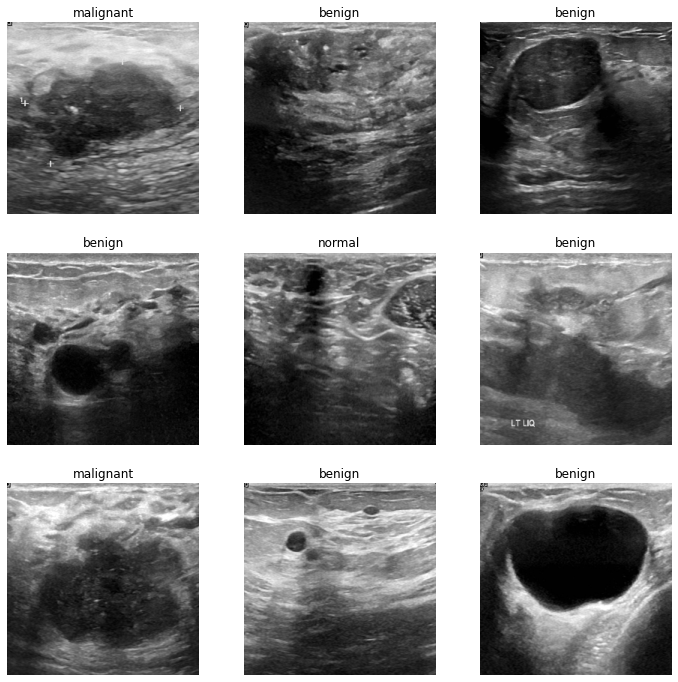

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(images[i]), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data split

In [ ]:
split_batches = tf.data.experimental.cardinality(data)
split_batches

<tf.Tensor: shape=(), dtype=int64, numpy=25>

In [ ]:
split_batches // 5

<tf.Tensor: shape=(), dtype=int64, numpy=5>

In [ ]:
dev_data = data.skip(split_batches // 5)
test_data = data.take(split_batches // 5)

In [ ]:
print('Number of dev batches: %d' % tf.data.experimental.cardinality(dev_data))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_data))

Number of dev batches: 20
Number of test batches: 5


# Configure performance

In [ ]:
dev_data = dev_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.02),
  # tf.keras.layers.experimental.preprocessing.RandomCrop(height=240, width=240),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.05,0.1), 
                                                        width_factor=(0.05,0.1))
])

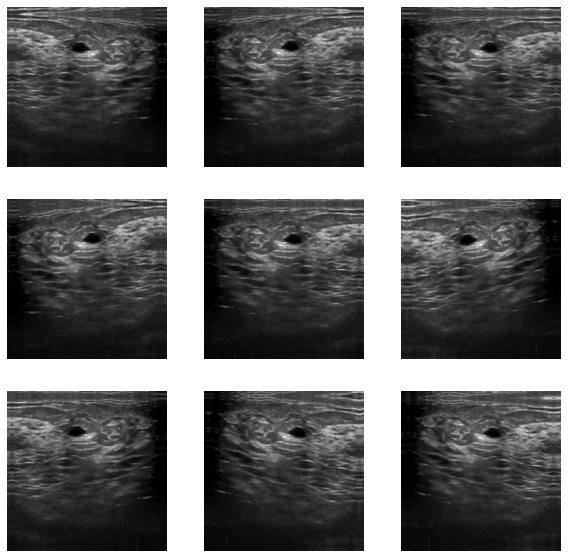

In [ ]:
for image, _ in dev_data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(np.squeeze(augmented_image[0] / 255), cmap='gray')
    plt.axis('off')

# Rescale pixel values?... Input preporcessing

In [ ]:
preprocess_input = tf.keras.applications.xception.preprocess_input

# Create base model

In [ ]:
IMG_SHAPE = IMG_SIZE + (1,)

In [ ]:
IMG_SHAPE

(256, 256, 1)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               classes=3,
                                               include_top=False,
                                              #  weights='imagenet'
                                               weights=None
                                               )

In [ ]:
base_model = tf.keras.applications.Xception(include_top=False,
                                            input_shape=IMG_SHAPE,
                                            weights=None)

## Freeze base

In [ ]:
base_model.trainable = True # False

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Add classification head

In [ ]:
image_batch, label_batch = next(iter(dev_data))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 8, 8, 2048])

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
feature_batch_average.shape

TensorShape([32, 2048])

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
prediction_batch, prediction_batch.shape

(<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
 array([[0.00395938],
        [0.00287694],
        [0.00364792],
        [0.00227872],
        [0.00423966],
        [0.00440947],
        [0.00270459],
        [0.00373441],
        [0.00459499],
        [0.00341837],
        [0.00433342],
        [0.00396008],
        [0.00375728],
        [0.00487434],
        [0.00358047],
        [0.00560522],
        [0.00297053],
        [0.00521055],
        [0.00227872],
        [0.0033462 ],
        [0.00486468],
        [0.00397736],
        [0.00342357],
        [0.00499474],
        [0.00331022],
        [0.00345959],
        [0.00357578],
        [0.00498931],
        [0.00219426],
        [0.00451388],
        [0.00550032],
        [0.00305985]], dtype=float32)>, TensorShape([32, 1]))

In [ ]:
inputs = tf.keras.Input(shape=(256, 256, 1))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True) # False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.1)(x) # 0.2
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

## Compile the model

In [ ]:
base_learning_rate = 0.001

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              # loss=tf.keras.losses.CategoricalCrossentropy(), #from_logits=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # loss=tf.keras.losses.CategoricalHinge(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 1)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 256, 256, 1)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 256, 256, 1)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20860904  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [ ]:
len(model.trainable_variables)

156

# Train the model

In [ ]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(dev_data)

20/20 [==============================] - 13s 374ms/step - loss: 0.4439 - accuracy: 0.6609


In [ ]:
print(f"initial loss: {loss0}")
print(f"initial accuracy: {accuracy0}")

initial loss: 0.44989585876464844
initial accuracy: 0.6709677577018738


In [ ]:
history = model.fit(dev_data,
                    epochs=initial_epochs,
                    validation_data=test_data)

Epoch 1/10
20/20 [==============================] - 46s 2s/step - loss: 0.5231 - accuracy: 0.6516 - val_loss: 0.3717 - val_accuracy: 0.6938
Epoch 2/10
20/20 [==============================] - 40s 2s/step - loss: 0.5148 - accuracy: 0.6371 - val_loss: 0.3554 - val_accuracy: 0.6812
Epoch 3/10
20/20 [==============================] - 40s 2s/step - loss: 0.5125 - accuracy: 0.6516 - val_loss: 0.5323 - val_accuracy: 0.6313
Epoch 4/10
20/20 [==============================] - 40s 2s/step - loss: 0.5577 - accuracy: 0.6403 - val_loss: 0.4651 - val_accuracy: 0.6812
Epoch 5/10
20/20 [==============================] - 40s 2s/step - loss: 0.4788 - accuracy: 0.6677 - val_loss: 0.4136 - val_accuracy: 0.6187
Epoch 6/10
20/20 [==============================] - 40s 2s/step - loss: 0.4877 - accuracy: 0.6597 - val_loss: 0.4160 - val_accuracy: 0.6875
Epoch 7/10
20/20 [==============================] - 40s 2s/step - loss: 0.4780 - accuracy: 0.6952 - val_loss: 0.4233 - val_accuracy: 0.6750
Epoch 8/10
20/20 [==

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

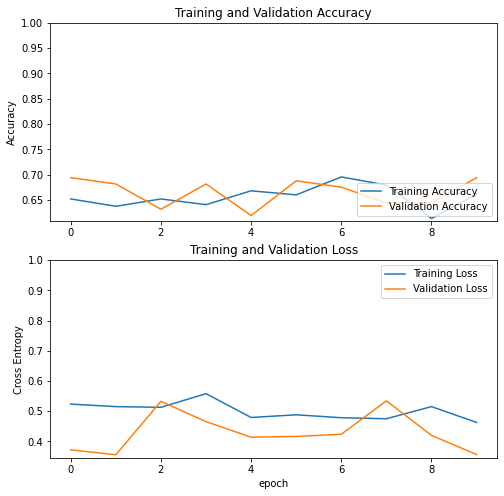

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning

In [ ]:
print(f"number of layers in base model: {len(base_model.layers)}")

number of layers in base model: 132


In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 110
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

## Compile the model

In [ ]:
model.compile( #loss=tf.keras.losses.CategoricalCrossentropy(), # from_logits=True),
              # loss=tf.keras.losses.CategoricalHinge(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), #/10),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/3),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 1)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 256, 256, 1)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 256, 256, 1)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20860904  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0   

In [ ]:
len(model.trainable_variables)

156

## Train finetune

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(dev_data,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                        #  callbacks=[callback],
                         validation_data=test_data)

Epoch 10/30
20/20 [==============================] - 47s 2s/step - loss: 0.4550 - accuracy: 0.6451 - val_loss: 0.3479 - val_accuracy: 0.6875
Epoch 11/30
20/20 [==============================] - 40s 2s/step - loss: 0.3799 - accuracy: 0.6887 - val_loss: 0.3079 - val_accuracy: 0.7125
Epoch 12/30
20/20 [==============================] - 39s 2s/step - loss: 0.3314 - accuracy: 0.7092 - val_loss: 0.3100 - val_accuracy: 0.6687
Epoch 13/30
20/20 [==============================] - 40s 2s/step - loss: 0.2958 - accuracy: 0.7139 - val_loss: 0.3247 - val_accuracy: 0.7250
Epoch 14/30
20/20 [==============================] - 39s 2s/step - loss: 0.3720 - accuracy: 0.6891 - val_loss: 0.2787 - val_accuracy: 0.7188
Epoch 15/30
20/20 [==============================] - 39s 2s/step - loss: 0.3111 - accuracy: 0.7140 - val_loss: 0.3533 - val_accuracy: 0.6938
Epoch 16/30
20/20 [==============================] - 40s 2s/step - loss: 0.3242 - accuracy: 0.7130 - val_loss: 0.3231 - val_accuracy: 0.7000
Epoch 17/30
2

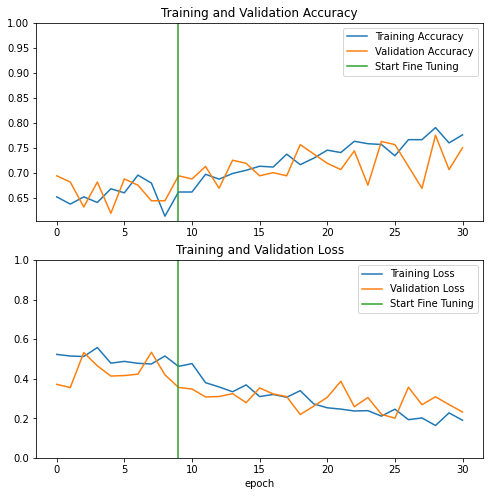

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Evaluation

In [ ]:
loss, accuracy = model.evaluate(test_data)
print(f'Test accuracy: {accuracy}, loss: {loss}')

5/5 [==============================] - 4s 387ms/step - loss: 0.2624 - accuracy: 0.7125
Test accuracy: 0.7124999761581421, loss: 0.26236993074417114


Predictions:
 [6.20917242e-04 2.63028749e-04 1.79165173e-02 1.09616536e-04
 2.42287330e-02 2.42127944e-02 2.92000221e-03 1.83337124e-03
 7.10925041e-03 2.89446441e-03 7.77126406e-04 2.56363349e-03
 8.22773800e-05 4.60665720e-03 4.96371500e-02 2.12561851e-03
 2.64182524e-03 1.48643002e-01 7.71613501e-04 3.07290889e-02
 6.40700310e-02 1.80971064e-02 2.06953257e-01 3.82010650e-04
 4.64833081e-02 1.43094942e-01 8.53748134e-05 1.32448480e-01
 7.50625180e-03 3.33394781e-02 1.03014763e-02 1.25516485e-02]
Labels:
 [0 0 2 0 2 1 0 0 0 1 0 0 0 0 1 0 0 2 0 0 1 0 1 0 2 1 0 1 0 1 0 1]


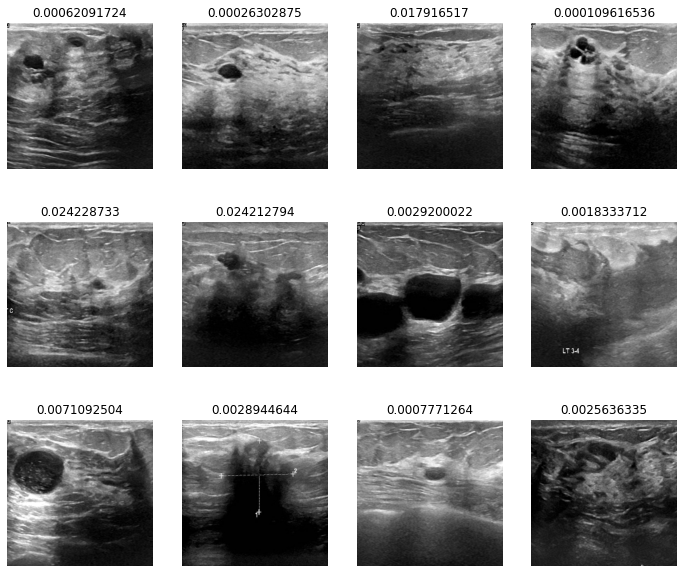

In [ ]:
image_batch, label_batch = test_data.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.softmax(predictions) #sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 14))
for i in range(12):
  ax = plt.subplot(4, 4, i + 1)
  # plt.imshow(image_batch[i].astype("uint8")) #np.squeeze(augmented_image[0] / 255), cmap='gray'
  plt.imshow(np.squeeze(image_batch[i].astype("uint8")), cmap='gray')
  # plt.title(class_names[predictions[i]])
  plt.title(predictions[i].numpy())
  plt.axis("off")

In [ ]:
predictions

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([0.15771802, 0.0034235 , 0.00086987, 0.02553478, 0.00469132,
       0.02478565, 0.10129263, 0.00088069, 0.00691821, 0.00214912,
       0.02374914, 0.00745886, 0.01218347, 0.0326146 , 0.00316712,
       0.03565286, 0.04020948, 0.02146817, 0.00422014, 0.00084757,
       0.06220546, 0.00075441, 0.00024282, 0.02590597, 0.18457858,
       0.09118209, 0.00283998, 0.0039101 , 0.01275673, 0.0246946 ,
       0.00329272, 0.0778013 ], dtype=float32)>